In [74]:
import os
import librosa
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

from sklearn.decomposition import PCA
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from tqdm import tqdm

In [2]:
def load_reference_file(reference_path):
    """Load the reference CSV file containing labels."""
    try:
        reference_df = pd.read_csv(reference_path, header=None)
        reference_df.columns = ['filename', 'label']
        reference_df['filename'] += '.wav'  # Ensure filenames match
        reference_df.set_index('filename', inplace=True)
        return reference_df
    except Exception as e:
        raise FileNotFoundError(f"Could not read reference CSV: {e}")

In [3]:
def extract_mfcc_features(file_path, fixed_length=130):
    """Extract MFCC features from an audio file."""
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        
        # Padding or truncating MFCCs to the fixed length
        if mfcc.shape[1] < fixed_length:
            padding = fixed_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, padding)), mode='constant')
        else:
            mfcc = mfcc[:, :fixed_length]
        
        return mfcc.flatten()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [4]:
def read_audio_files(data_path, reference_df, fixed_length=130):
    """Process audio files to extract MFCCs and their corresponding labels."""
    mfccs = []
    labels = []
    
    # Get sorted list of files
    file_list = sorted(os.listdir(data_path))
    
    for file in file_list:
        if file.endswith('.wav'):
            file_path = os.path.join(data_path, file)
            print(f"Processing file: {file_path}")  # Debugging line
            
            mfcc = extract_mfcc_features(file_path, fixed_length)
            if mfcc is not None:
                mfccs.append(mfcc)
                
                # Fetch label from the reference file
                if file in reference_df.index:
                    label = reference_df.loc[file, 'label']
                    labels.append(label)
                else:
                    print(f"Label for {file} not found in reference.csv. Skipping.")
    
    return np.array(mfccs), np.array(labels)


In [5]:
def process_dataset(base_path, folders, fixed_length=130):
    """Process multiple folders to extract MFCCs and labels."""
    all_mfccs = []
    all_labels = []
    
    for folder in folders:
        data_path = os.path.join(base_path, folder)
        reference_path = os.path.join(data_path, 'REFERENCE.csv')
        
        reference_df = load_reference_file(reference_path)
        folder_mfccs, folder_labels = read_audio_files(data_path, reference_df, fixed_length)
        
        all_mfccs.extend(folder_mfccs)
        all_labels.extend(folder_labels)
    
    return np.array(all_mfccs), np.array(all_labels)


In [6]:
base_path = './data/training_2016'

In [7]:
folders = ['training-a', 'training-b', 'training-c', 'training-d', 'training-e', 'training-f']

In [8]:

# Process the dataset and combine features and labels
all_mfccs, all_labels = process_dataset(base_path, folders);

Processing file: ./data/training_2016/training-a/a0001.wav
Processing file: ./data/training_2016/training-a/a0002.wav
Processing file: ./data/training_2016/training-a/a0003.wav
Processing file: ./data/training_2016/training-a/a0004.wav
Processing file: ./data/training_2016/training-a/a0005.wav
Processing file: ./data/training_2016/training-a/a0006.wav
Processing file: ./data/training_2016/training-a/a0007.wav
Processing file: ./data/training_2016/training-a/a0008.wav
Processing file: ./data/training_2016/training-a/a0009.wav
Processing file: ./data/training_2016/training-a/a0010.wav
Processing file: ./data/training_2016/training-a/a0011.wav
Processing file: ./data/training_2016/training-a/a0012.wav
Processing file: ./data/training_2016/training-a/a0013.wav
Processing file: ./data/training_2016/training-a/a0014.wav
Processing file: ./data/training_2016/training-a/a0015.wav
Processing file: ./data/training_2016/training-a/a0016.wav
Processing file: ./data/training_2016/training-a/a0017.w

In [9]:
# Save combined features and labels for future use
np.save('mfcc_features.npy', all_mfccs)
np.save('labels.npy', all_labels)

In [10]:
print(all_mfccs[1])
print(all_labels[1])

[-268.50842 -218.85399 -224.99608 ...    0.         0.         0.     ]
1


In [11]:
def normalize_mfcc(mfcc):
    """Normalize MFCC values to the range [0, 255] for image representation."""
    mfcc_min = np.min(mfcc)
    mfcc_max = np.max(mfcc)
    
    if mfcc_max - mfcc_min == 0:
        # If max and min are the same, return an array of zeros (avoid division by zero)
        return np.zeros_like(mfcc)
    
    return 255 * (mfcc - mfcc_min) / (mfcc_max - mfcc_min)

In [12]:
def mfcc_to_rgb(mfcc, target_size=(224, 224)):
    """Convert MFCC to RGB image representation."""
    # Normalize MFCC values
    mfcc_normalized = normalize_mfcc(mfcc)
    
    # Resize the MFCC to the desired target size
    resized_mfcc = cv2.resize(mfcc_normalized, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Convert single-channel to 3-channel by replicating across R, G, and B
    rgb_image = np.stack([resized_mfcc] * 3, axis=-1).astype(np.uint8)
    
    return rgb_image

In [13]:
def reshape_mfcc_features(all_mfccs, n_mfcc=13):
    """Reshape the flattened MFCC features into a 3D array (samples, n_mfcc, time_steps)."""
    num_samples = all_mfccs.shape[0]
    flattened_dim = all_mfccs.shape[1]
    
    # Calculate the number of time steps
    time_steps = flattened_dim // n_mfcc
    if flattened_dim % n_mfcc != 0:
        raise ValueError(f"Inconsistent dimensions: Cannot reshape {flattened_dim} into (13, time_steps).")
    
    return all_mfccs.reshape((num_samples, n_mfcc, time_steps))

In [14]:
def display_images(mfcc_features, num_images=3, target_size=(224, 224)):
    """Display a few MFCC features as RGB images."""
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        mfcc = mfcc_features[i]  # Extract individual MFCC sample
        rgb_image = mfcc_to_rgb(mfcc, target_size)
        
        # Plot the RGB image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(rgb_image)
        plt.title(f"MFCC Sample {i + 1}")
        plt.axis('off')
    
    plt.show()

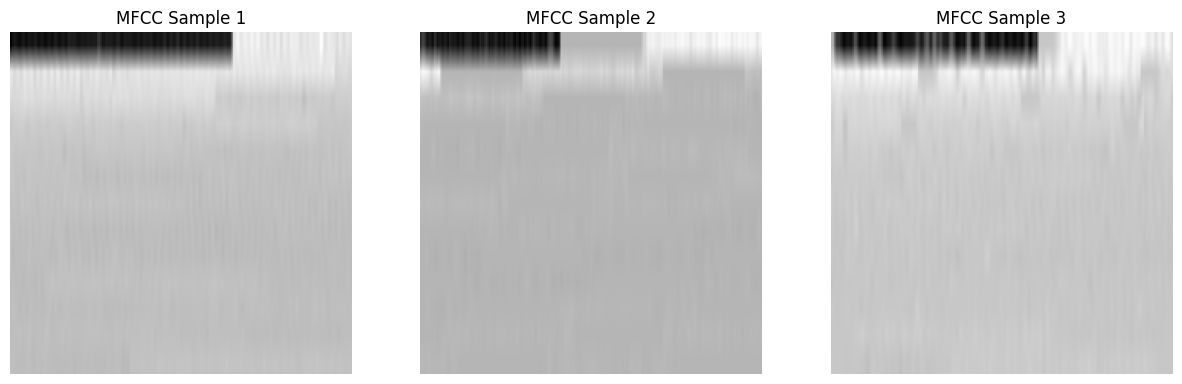

In [15]:
try:
    # Parameters
    n_mfcc = 13  # Number of MFCC coefficients per time step
    num_samples = all_mfccs.shape[0]
    
    # Reshape MFCCs to 2D array (samples, n_mfcc, time_steps)
    all_mfccs_reshaped = reshape_mfcc_features(all_mfccs, n_mfcc)

    # Display 2-3 images from the dataset
    display_images(all_mfccs_reshaped, num_images=3, target_size=(224, 224))

except Exception as e:
    print(f"Error processing MFCC features: {e}")

In [16]:
def extract_mel_spectrogram(file_path, fixed_length=130, n_mels=128):
    """Extract Mel Spectrogram from an audio file."""
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Pad or truncate to the fixed length
        if mel_spec_db.shape[1] < fixed_length:
            padding = fixed_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, padding)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :fixed_length]
    except Exception as e:
        raise ValueError(f"Error processing file {file_path}: {e}")
    
    return mel_spec_db

In [17]:
def read_dataset_with_labels(data_path, reference_path, fixed_length=130, n_mels=128):
    """Read the dataset and extract Mel Spectrograms along with corresponding labels."""
    mel_specs = []
    labels = []
    
    # Load reference CSV to get labels
    reference_df = load_reference_file(reference_path)
    
    # Process all audio files in the folder
    file_list = sorted(os.listdir(data_path))
    
    for file in file_list:
        if file.endswith('.wav'):
            file_path = os.path.join(data_path, file)
            try:
                mel_spec_db = extract_mel_spectrogram(file_path, fixed_length, n_mels)
                mel_specs.append(mel_spec_db)
                if file in reference_df.index:
                    label = reference_df.loc[file, 'label']
                    labels.append(label)
                else:
                    print(f"Warning: Label for {file} not found. Skipping.")
            except Exception as e:
                print(f"Error with file {file}: {e}")
    
    # Ensure there are no missing Mel Spectrograms
    if not mel_specs:
        raise ValueError("No valid Mel Spectrogram data found. Please check the dataset.")

    return np.array(mel_specs), np.array(labels)

In [18]:
def process_all_folders(base_path, folders):
    """Process all folders, extracting Mel Spectrograms and labels."""
    all_mel_specs = []
    all_labels = []

    for folder in folders:
        data_path = os.path.join(base_path, folder)
        reference_path = os.path.join(data_path, 'REFERENCE.csv')

        try:
            folder_mel_specs, folder_labels = read_dataset_with_labels(data_path, reference_path)
            all_mel_specs.extend(folder_mel_specs)
            all_labels.extend(folder_labels)
        except Exception as e:
            print(f"Error processing folder {folder}: {e}")
    
    return np.array(all_mel_specs), np.array(all_labels)

In [19]:
try:
        # Process all folders
        all_mel_specs, all_labels = process_all_folders(base_path, folders)

        # Check the shapes of the combined data
        print(f"Total Mel Spectrogram shape: {all_mel_specs.shape}, Total Labels shape: {all_labels.shape}")

        # Save combined features and labels for future use
        np.save('mel_spectrogram_features.npy', all_mel_specs)
        np.save('labels.npy', all_labels)
        
except Exception as e:
        print(f"Error during dataset processing: {e}")

Total Mel Spectrogram shape: (3240, 128, 130), Total Labels shape: (3240,)


In [20]:
def display_mel_spectrograms(mel_specs, num_images=3):
    """Display Mel Spectrograms with a default color map."""
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        mel_spec = mel_specs[i]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Mel Spectrogram {i + 1}")
        plt.axis('off')
    plt.show()

In [21]:
def display_log_mel_spectrograms(mel_specs, num_images=3):
    """Display Mel Spectrograms with log scaling."""
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        mel_spec = mel_specs[i]
        mel_spec_log = np.log1p(mel_spec)  # Apply log scaling
        plt.subplot(1, num_images, i + 1)
        plt.imshow(mel_spec_log, aspect='auto', origin='lower', cmap='inferno')
        plt.title(f"Log-scaled Mel Spectrogram {i + 1}")
        plt.axis('off')
    plt.show()

In [22]:
def display_average_mel_spectrogram(mel_specs):
    """Display the average Mel Spectrogram across all samples."""
    avg_mel_spec = np.mean(mel_specs, axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(avg_mel_spec, aspect='auto', origin='lower', cmap='viridis')
    plt.title("Average Mel Spectrogram")
    plt.colorbar(format="%+2.0f dB")
    plt.axis('off')
    plt.show()

In [23]:
def display_top_mel_spectrograms(mel_specs, top_n=5):
    """Display top N Mel Spectrograms based on energy."""
    energies = [np.sum(mel_spec) for mel_spec in mel_specs]  # Total energy in each Mel spectrogram
    top_indices = np.argsort(energies)[-top_n:]  # Indices of the top N spectrograms by energy
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_indices):
        mel_spec = mel_specs[idx]
        plt.subplot(1, top_n, i + 1)
        plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Top Mel Spectrogram {i + 1}")
        plt.axis('off')
    plt.show()

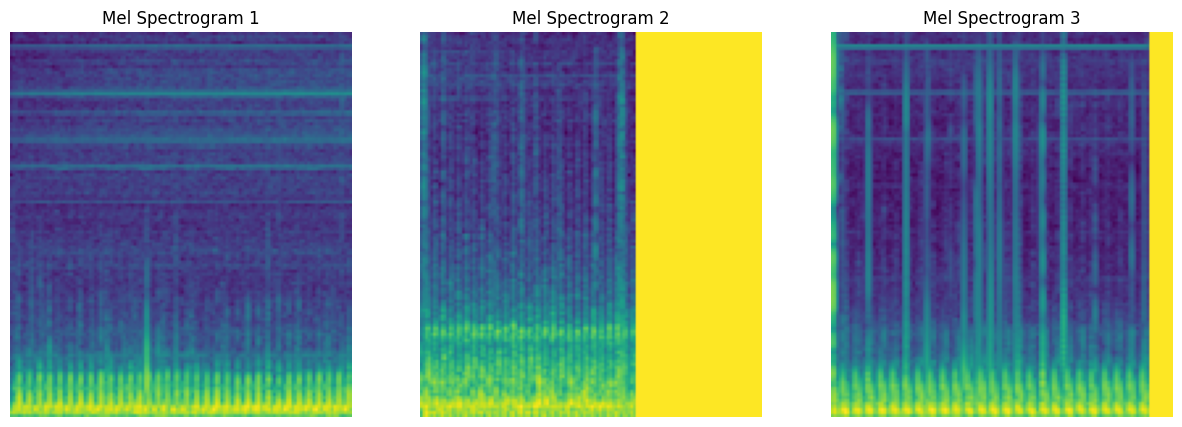

In [24]:
# Display 2-3 Mel Spectrograms (original)
display_mel_spectrograms(all_mel_specs, num_images=3)

/var/folders/f6/q3w6f44s5jvc8vq247_z0l7c0000gn/T/ipykernel_17040/2182027507.py:6: RuntimeWarning: invalid value encountered in log1p
  mel_spec_log = np.log1p(mel_spec)  # Apply log scaling


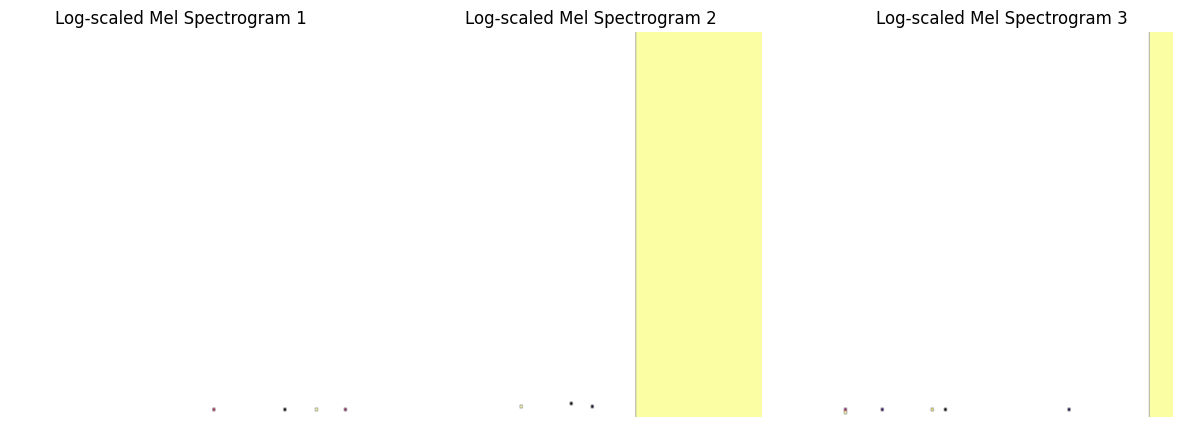

In [25]:
# Display log-scaled Mel Spectrograms
display_log_mel_spectrograms(all_mel_specs, num_images=3)

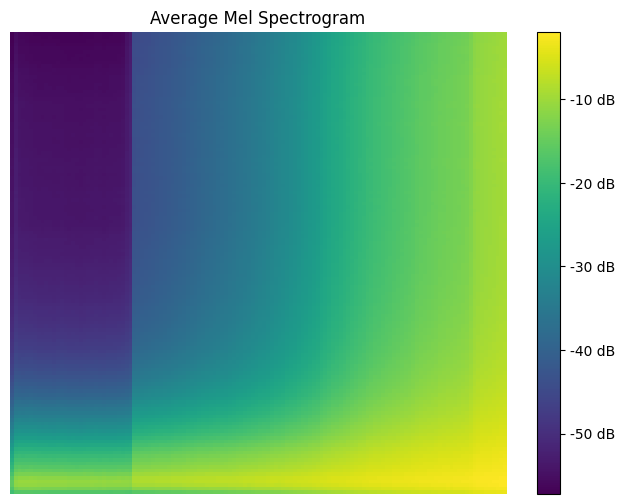

In [26]:
# Display the average Mel Spectrogram across all samples
display_average_mel_spectrogram(all_mel_specs)

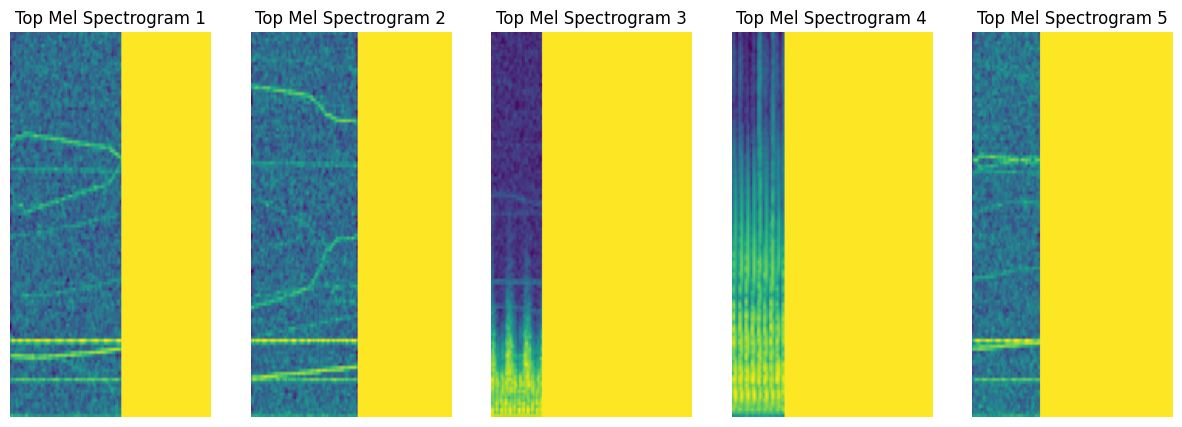

In [27]:
# Display the top 5 Mel Spectrograms based on energy
display_top_mel_spectrograms(all_mel_specs, top_n=5)

In [30]:
def display_energy_distribution(mel_specs):
    """Display the distribution of energy across Mel Spectrograms."""
    energies = [np.sum(mel_spec) for mel_spec in mel_specs]  # Total energy in each Mel spectrogram
    plt.figure(figsize=(8, 6))
    plt.hist(energies, bins=50, color='blue', alpha=0.7)
    plt.title("Energy Distribution Across Mel Spectrograms")
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.show()

In [31]:
def display_pca_mel_spectrograms(mel_specs, n_components=2):
    """Display PCA components of Mel Spectrograms."""
    mel_specs_flattened = mel_specs.reshape(mel_specs.shape[0], -1)  # Flatten spectrograms into vectors
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(mel_specs_flattened)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_components[:, 0], pca_components[:, 1], c='blue', alpha=0.7)
    plt.title(f"PCA of Mel Spectrograms (First {n_components} Components)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

In [32]:
def display_normalized_vs_unnormalized(mel_specs, num_images=3):
    """Display comparison of normalized and unnormalized Mel Spectrograms."""
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        mel_spec = mel_specs[i]
        
        # Normalized version
        mel_spec_normalized = (mel_spec - np.min(mel_spec)) / (np.max(mel_spec) - np.min(mel_spec))
        
        # Plot Unnormalized
        plt.subplot(2, num_images, i + 1)
        plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Unnormalized {i + 1}")
        plt.axis('off')
        
        # Plot Normalized
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(mel_spec_normalized, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Normalized {i + 1}")
        plt.axis('off')
            
    plt.tight_layout()
    plt.show()

In [33]:
def display_mean_frequency_distribution(mel_specs, sr=22050):
    """Display the distribution of mean frequencies across the Mel Spectrograms."""
    mean_frequencies = []
    for mel_spec in mel_specs:
        # Get Mel frequencies corresponding to each Mel frequency bin
        freq_axis = librosa.mel_frequencies(n_mels=mel_spec.shape[0], fmin=0, fmax=sr / 2)
        
        # Calculate the weighted mean frequency across all time frames
        weighted_frequencies = np.dot(mel_spec.T, freq_axis)  # T to align dimensions (130, 128) -> (130,)
        mean_frequency = np.mean(weighted_frequencies)  # Average frequency across all time steps
        
        mean_frequencies.append(mean_frequency)
    
    plt.figure(figsize=(8, 6))
    plt.hist(mean_frequencies, bins=50, color='green', alpha=0.7)
    plt.title("Distribution of Mean Frequencies Across Mel Spectrograms")
    plt.xlabel("Mean Frequency (Hz)")
    plt.ylabel("Frequency")
    plt.show()

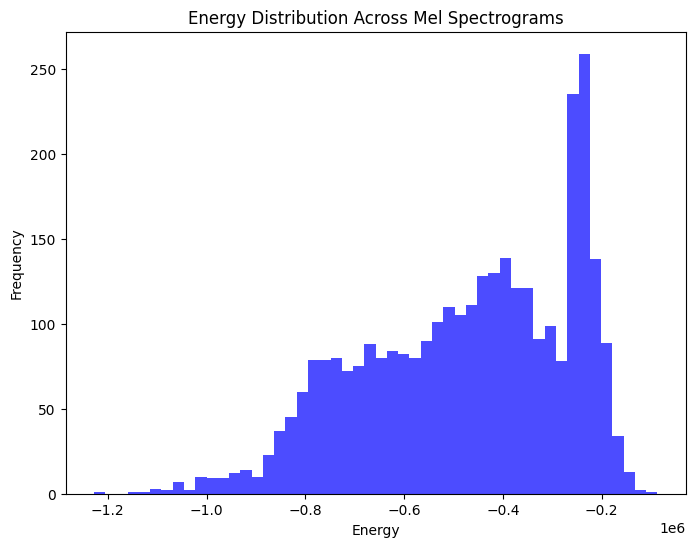

In [34]:
# Display the energy distribution across Mel Spectrograms
display_energy_distribution(all_mel_specs)

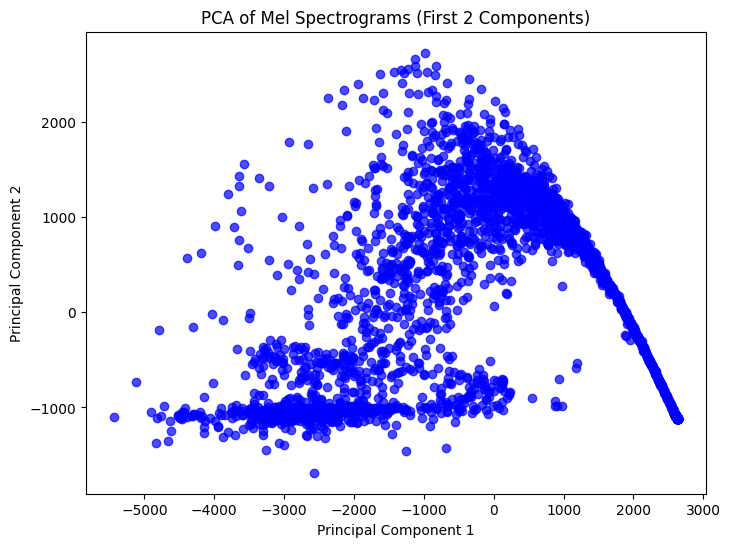

In [35]:
# Display the PCA of Mel Spectrograms (2 components)
display_pca_mel_spectrograms(all_mel_specs)

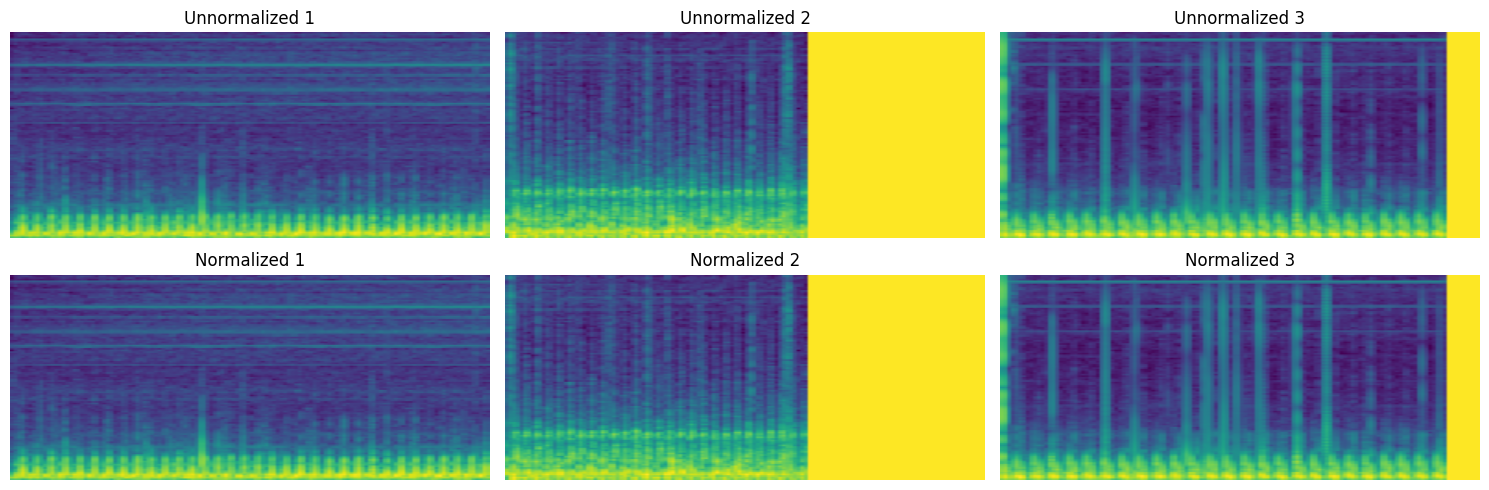

In [36]:
# Display normalized vs unnormalized Mel Spectrograms (2-3 samples)
display_normalized_vs_unnormalized(all_mel_specs, num_images=3)

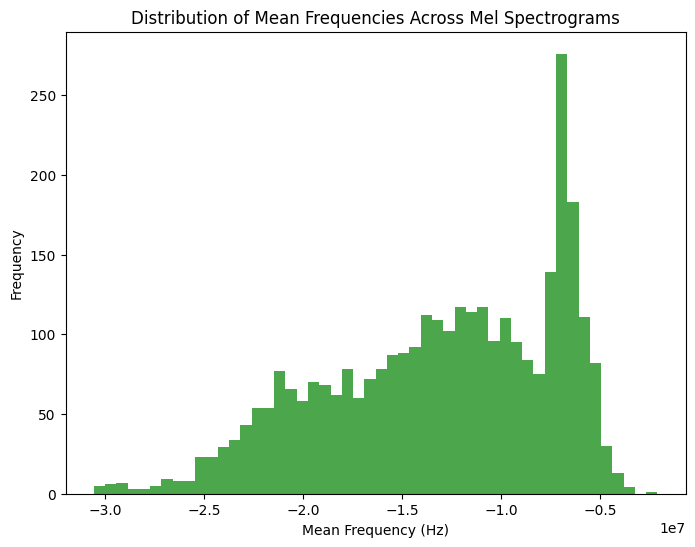

In [37]:
# Display the distribution of mean frequencies across Mel Spectrograms
display_mean_frequency_distribution(all_mel_specs)

In [40]:
# Constants for audio processing
SAMPLE_RATE = 22050
DURATION = 2  # Duration in seconds
N_MELS = 64
N_FFT = 2048
HOP_LENGTH = 512
FIXED_LENGTH = 87  # Fixed time frames after padding/truncation

In [41]:
# Function to load and preprocess audio into mel spectrogram
def load_and_preprocess_audio(file_path):
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    if len(audio) < SAMPLE_RATE * DURATION:
        audio = np.pad(audio, (0, SAMPLE_RATE * DURATION - len(audio)))
    else:
        audio = audio[:SAMPLE_RATE * DURATION]
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels
    return mel_spec_db

In [42]:
# Data augmentation function
def augment_audio(audio, sr=SAMPLE_RATE, augment_prob=0.5):
    if np.random.random() < augment_prob:
        stretch_factor = np.random.uniform(0.8, 1.2)
        audio = librosa.effects.time_stretch(audio, rate=stretch_factor)

    if np.random.random() < augment_prob:
        n_steps = np.random.randint(-4, 5)
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

    if np.random.random() < augment_prob:
        noise_factor = np.random.uniform(0.005, 0.02)
        noise = np.random.randn(len(audio))
        audio = audio + noise_factor * noise
    
    if np.random.random() < augment_prob:
        gain_factor = np.random.uniform(0.8, 1.2)
        audio = audio * gain_factor

    target_length = sr * DURATION
    if len(audio) > target_length:
        start = np.random.randint(0, len(audio) - target_length)
        audio = audio[start:start + target_length]
    elif len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))

    audio = np.clip(audio, -1, 1)
    return audio

In [ ]:
# PyTorch Dataset for Heart Sound Classification
class HeartSoundDataset(Dataset):
    def __init__(self, file_paths, labels, augment=False, fixed_length=FIXED_LENGTH):
        self.file_paths = file_paths
        self.labels = labels
        self.augment = augment
        self.fixed_length = fixed_length
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load the audio file
        audio, sr = librosa.load(self.file_paths[idx], sr=SAMPLE_RATE, duration=DURATION)

        # Apply augmentation if enabled
        if self.augment:
            audio = augment_audio(audio, sr=SAMPLE_RATE, augment_prob=0.5)

        # Generate mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize the spectrogram
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

        # Debugging: print the shape of the mel spectrogram
        # print(f"Mel spectrogram shape: {mel_spec_db.shape}")
        
        # Pad or truncate the spectrogram to the fixed length
        if mel_spec_db.shape[1] < self.fixed_length:
            pad_width = self.fixed_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :self.fixed_length]

        label = self.labels[idx]
        return torch.FloatTensor(mel_spec_db).unsqueeze(0), torch.tensor(label)


In [67]:
# Collate function for batching
def collate_fn(batch):
    specs, labels = zip(*batch)
    specs = torch.stack(specs)
    labels = torch.stack(labels)
    return specs, labels

In [68]:
# Helper function to remap labels
def remap_labels(labels):
    return [0 if label == -1 else label for label in labels]

In [69]:
# Function to prepare dataset and labels
def prepare_dataset(data_path, reference_path):
    file_paths = []
    labels = []

    reference_df = pd.read_csv(reference_path, header=None)
    reference_df.columns = ['filename', 'label']
    reference_df['filename'] += '.wav'  # Append '.wav' to match audio files

    for file in sorted(os.listdir(data_path)):
        if file.endswith('.wav'):
            file_path = os.path.join(data_path, file)
            if file in reference_df['filename'].values:
                file_paths.append(file_path)
                label = reference_df.loc[reference_df['filename'] == file, 'label'].values[0]
                labels.append(int(label))
    labels = remap_labels(labels)
    return file_paths, labels

In [ ]:
try:
    # Specify base path and dataset folders
    base_path = './data/training_2016'
    
    train_folders = ['training-a', 'training-b', 'training-c', 'training-d', 'training-e', 'training-f']
    validation_folder = 'validation'
    # Initialize lists to store file paths and labels for training and validation
    train_file_paths, train_labels = [], []
    val_file_paths, val_labels = [], []

    # Process training folders
    for folder in train_folders:
        data_path = os.path.join(base_path, folder)
        reference_path = os.path.join(data_path, 'REFERENCE.csv')
        file_paths, labels = prepare_dataset(data_path, reference_path)
        train_file_paths.extend(file_paths)
        train_labels.extend(labels)

    # Process validation folder
    validation_data_path = os.path.join(base_path, validation_folder)
    validation_reference_path = os.path.join(validation_data_path, 'REFERENCE.csv')
    val_file_paths, val_labels = prepare_dataset(validation_data_path, validation_reference_path)

    # Create Dataset instances for training and validation
    train_dataset = HeartSoundDataset(train_file_paths, train_labels, augment=True)
    val_dataset = HeartSoundDataset(val_file_paths, val_labels, augment=False)
    print("training: ", train_dataset[0])
    print("val_dataset: ", val_dataset.fixed_length)
    # Initialize DataLoader instances for batching and shuffling
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    # Output dataset information
    print(f"Train Dataset: {len(train_dataset)} samples")
    print(f"Validation Dataset: {len(val_dataset)} samples")
    print(train_dataset[0])
    print(train_dataset[8]);
    
except Exception as e:
    print(f"Error processing {file_path}: {e}")
    

Mel spectrogram shape: (64, 87)
training:  (tensor([[[0.8147, 0.8329, 0.8317,  ..., 0.7458, 0.7033, 0.6292],
         [0.6743, 0.6620, 0.6606,  ..., 0.6255, 0.6337, 0.6131],
         [0.5826, 0.5579, 0.5873,  ..., 0.5532, 0.5766, 0.5623],
         ...,
         [0.1690, 0.0936, 0.0000,  ..., 0.0000, 0.0000, 0.0055],
         [0.1674, 0.0920, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
         [0.1665, 0.0910, 0.0000,  ..., 0.0000, 0.0000, 0.0029]]]), tensor(1))
val_dataset:  87
Train Dataset: 3240 samples
Validation Dataset: 301 samples
Mel spectrogram shape: (64, 87)
(tensor([[[0.5653, 0.6550, 0.6561,  ..., 0.5717, 0.5367, 0.4697],
         [0.2842, 0.3094, 0.3347,  ..., 0.3012, 0.3588, 0.2995],
         [0.1654, 0.2606, 0.2344,  ..., 0.1502, 0.1925, 0.2285],
         ...,
         [0.1527, 0.1801, 0.1867,  ..., 0.2199, 0.1895, 0.1464],
         [0.1692, 0.2110, 0.2123,  ..., 0.2239, 0.2097, 0.1535],
         [0.1561, 0.2051, 0.2214,  ..., 0.2084, 0.2308, 0.1764]]]), tensor(1))
Mel spectr

In [75]:
# Define the CNN model with transfer learning using MobileNetV2
class HeartSoundNet(nn.Module):
    def __init__(self, num_classes):
        super(HeartSoundNet, self).__init__()
        
        # Load a pre-trained MobileNetV2 model
        self.mobilenetv2 = models.mobilenet_v2(pretrained=True)
        
        # Modify the first convolutional layer to accept 1-channel input (grayscale)
        self.mobilenetv2.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        
        # Use the feature extractor part of MobileNetV2 (removes the classifier part)
        self.feature_extractor = self.mobilenetv2.features
                # Add custom classification layers
        self.fc1 = nn.Linear(1280, 512)  # Fully connected layer after feature extraction
        self.batch_norm = nn.BatchNorm1d(512)  # Batch normalization
        self.fc2 = nn.Linear(512, num_classes)  # Final classification layer

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features using MobileNetV2
        x = x.mean([2, 3])  # Global average pooling to reduce the spatial dimensions
        x = F.relu(self.fc1(x))
        x = self.batch_norm(x)  # Apply batch normalization
        x = self.fc2(x)
        return x

In [76]:
# Training function with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float('inf')
    patience_counter = 0  # Tracks epochs without improvement
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        if scheduler:
            scheduler.step(val_acc)
            
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Early Stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f"New best model saved with validation loss: {val_loss:.4f}")
            patience_counter = 0  # Reset the counter if validation loss improves
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered!")
                break
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [77]:
# Function to plot the training/validation losses and accuracies
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot Losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Model setup and training
num_classes = 2  # Adjust based on your dataset (e.g., normal vs. abnormal heart sounds)
learning_rate = 0.0001
num_epochs = 40
early_stopping_patience = 10  # Stop training if no improvement for 10 epochs

# Initialize the model
model = HeartSoundNet(num_classes=num_classes)

# Optionally, calculate class weights for imbalanced classes
# Uncomment and adjust based on dataset distribution if needed:
# class_weights = torch.tensor([weight_class_0, weight_class_1], dtype=torch.float).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# For now, we will use CrossEntropyLoss without class weights
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Using StepLR scheduler (decay learning rate every 5 epochs by a factor of 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Assuming `train_loader` and `val_loader` are already defined
trained_model, train_losses, val_losses, train_acc, val_acc = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs, 
    scheduler, 
    early_stopping_patience=early_stopping_patience  # Add early stopping
)

# Save the trained model after training
torch.save(trained_model.state_dict(), 'heart_sound_model.pth')

# Plot the training and validation losses/accuracies
plot_training_history(train_losses, val_losses, train_acc, val_acc)


/Users/yanxu/miniconda3/envs/heartSound/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yanxu/miniconda3/envs/heartSound/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/yanxu/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100.0%
Epoch 1/40 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:   1%|          | 1/102 [00:01<02:02,  1.22s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:   2%|▏         | 2/102 [00:02<01:56,  1.17s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:   3%|▎         | 3/102 [00:03<01:53,  1.15s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:   4%|▍         | 4/102 [00:04<01:56,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:   5%|▍         | 5/102 [00:06<01:58,  1.22s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:   6%|▌         | 6/102 [00:07<01:56,  1.22s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:   7%|▋         | 7/102 [00:08<01:53,  1.20s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:   8%|▊         | 8/102 [00:09<01:52,  1.20s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:   9%|▉         | 9/102 [00:10<01:48,  1.16s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  10%|▉         | 10/102 [00:11<01:46,  1.16s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  11%|█         | 11/102 [00:13<01:47,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  12%|█▏        | 12/102 [00:14<01:47,  1.20s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  13%|█▎        | 13/102 [00:15<01:45,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  14%|█▎        | 14/102 [00:16<01:45,  1.20s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  15%|█▍        | 15/102 [00:17<01:45,  1.21s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  16%|█▌        | 16/102 [00:19<01:43,  1.21s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  17%|█▋        | 17/102 [00:20<01:41,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  18%|█▊        | 18/102 [00:21<01:40,  1.20s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  19%|█▊        | 19/102 [00:22<01:39,  1.20s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  20%|█▉        | 20/102 [00:23<01:37,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  21%|██        | 21/102 [00:25<01:37,  1.21s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  22%|██▏       | 22/102 [00:26<01:35,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  23%|██▎       | 23/102 [00:27<01:45,  1.33s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  24%|██▎       | 24/102 [00:29<01:42,  1.31s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  25%|██▍       | 25/102 [00:30<01:37,  1.26s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  25%|██▌       | 26/102 [00:31<01:34,  1.24s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  26%|██▋       | 27/102 [00:32<01:31,  1.21s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  27%|██▋       | 28/102 [00:33<01:29,  1.20s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  28%|██▊       | 29/102 [00:35<01:27,  1.20s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  29%|██▉       | 30/102 [00:36<01:25,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  30%|███       | 31/102 [00:37<01:24,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  31%|███▏      | 32/102 [00:38<01:21,  1.16s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  32%|███▏      | 33/102 [00:39<01:21,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  33%|███▎      | 34/102 [00:40<01:19,  1.17s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  34%|███▍      | 35/102 [00:42<01:20,  1.20s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  35%|███▌      | 36/102 [00:43<01:19,  1.20s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  36%|███▋      | 37/102 [00:44<01:17,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  37%|███▋      | 38/102 [00:45<01:15,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  38%|███▊      | 39/102 [00:46<01:12,  1.15s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  39%|███▉      | 40/102 [00:47<01:12,  1.17s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  40%|████      | 41/102 [00:49<01:11,  1.17s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  41%|████      | 42/102 [00:50<01:09,  1.17s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  42%|████▏     | 43/102 [00:51<01:09,  1.17s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  43%|████▎     | 44/102 [00:52<01:08,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  44%|████▍     | 45/102 [00:53<01:06,  1.16s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  45%|████▌     | 46/102 [00:54<01:05,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  46%|████▌     | 47/102 [00:56<01:05,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  47%|████▋     | 48/102 [00:57<01:03,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  48%|████▊     | 49/102 [00:58<01:01,  1.16s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  49%|████▉     | 50/102 [00:59<01:00,  1.17s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  50%|█████     | 51/102 [01:00<00:59,  1.17s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  51%|█████     | 52/102 [01:01<00:57,  1.16s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  52%|█████▏    | 53/102 [01:03<00:56,  1.16s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  53%|█████▎    | 54/102 [01:04<00:56,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  54%|█████▍    | 55/102 [01:05<00:56,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  55%|█████▍    | 56/102 [01:06<00:54,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  56%|█████▌    | 57/102 [01:07<00:52,  1.16s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  57%|█████▋    | 58/102 [01:08<00:50,  1.15s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  58%|█████▊    | 59/102 [01:10<00:48,  1.14s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  59%|█████▉    | 60/102 [01:11<00:47,  1.13s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  60%|█████▉    | 61/102 [01:12<00:45,  1.12s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  61%|██████    | 62/102 [01:13<00:47,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  62%|██████▏   | 63/102 [01:14<00:47,  1.22s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  63%|██████▎   | 64/102 [01:16<00:45,  1.21s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  64%|██████▎   | 65/102 [01:17<00:43,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  65%|██████▍   | 66/102 [01:18<00:42,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  66%|██████▌   | 67/102 [01:19<00:42,  1.22s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  67%|██████▋   | 68/102 [01:20<00:40,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  68%|██████▊   | 69/102 [01:22<00:39,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  69%|██████▊   | 70/102 [01:23<00:37,  1.17s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  70%|██████▉   | 71/102 [01:24<00:36,  1.18s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  71%|███████   | 72/102 [01:25<00:34,  1.16s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  72%|███████▏  | 73/102 [01:26<00:33,  1.15s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  73%|███████▎  | 74/102 [01:27<00:32,  1.16s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  74%|███████▎  | 75/102 [01:28<00:31,  1.16s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  75%|███████▍  | 76/102 [01:30<00:31,  1.19s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  75%|███████▌  | 77/102 [01:31<00:32,  1.29s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/40 - Training:  76%|███████▋  | 78/102 [01:33<00:33,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec